# SARIMAX 

<a href="https://colab.research.google.com/github/omdgit/AppliedTimeSeriesAnalysisWithPython/blob/main/my work/HOTSAP_SARIMAX.ipynb " target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>  

https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from itertools import product
from matplotlib import pyplot as plt, dates as mdates, ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import sys

sys.path.append('../../My-Code/')
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

import timetools as tt

%matplotlib inline

In [76]:
plt.style.use('seaborn')
# plt.rcParams['figure.figsize'] = [10, 7.5]

## Load data: United States Macroeconomic Dataset 

In [77]:
macro_data = sm.datasets.macrodata.load_pandas()

In [78]:
macro_data = macro_data.data

In [79]:
macro_data.info()
macro_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


## Visualization of data

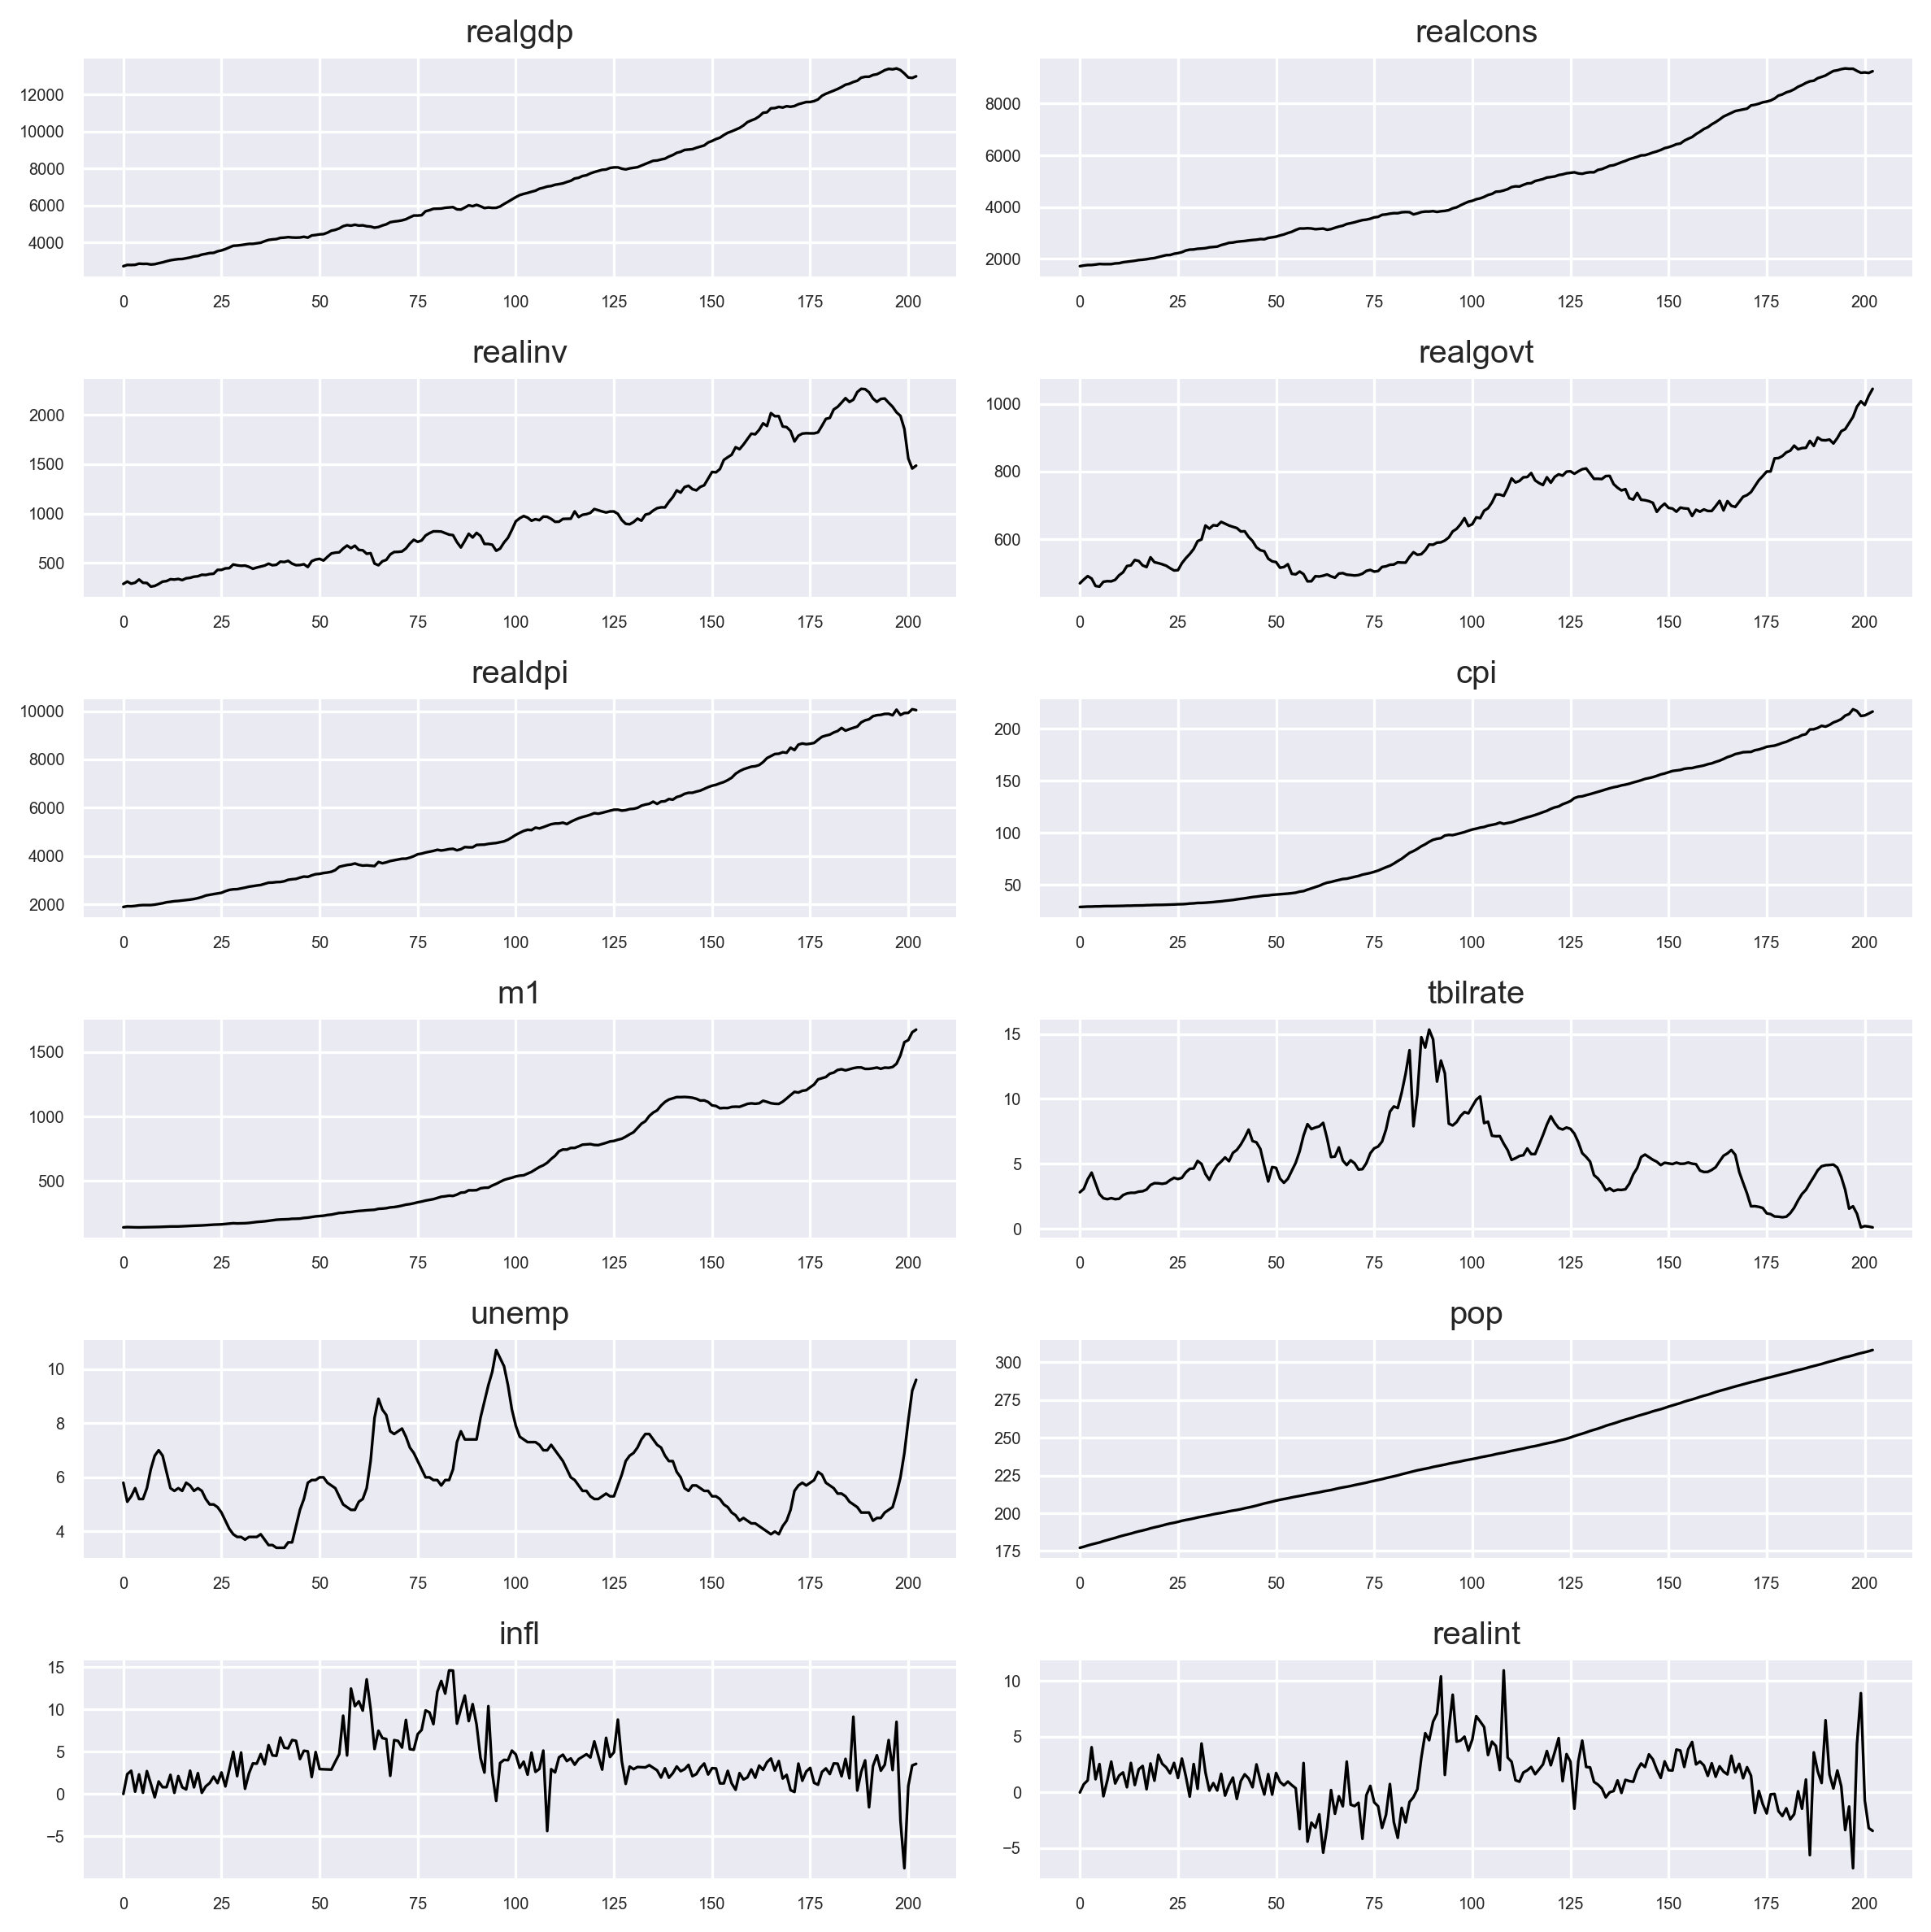

In [80]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=240, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

## Stationarity

In [81]:
tt.adf_v2(macro_data['realgdp'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                -6.305696e+00
p-value                        3.327882e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64

The time series is stationary.


In [82]:
tt.adf_v2(macro_data['realcons'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                  -4.204306
p-value                          0.000648
#Lags Used                       3.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64

The time series is stationary.


In [83]:
tt.adf_v2(macro_data['realinv'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                  -5.350595
p-value                          0.000004
#Lags Used                       2.000000
Number of Observations Used    199.000000
Critical Value (1%)             -3.463645
Critical Value (5%)             -2.876176
Critical Value (10%)            -2.574572
dtype: float64

The time series is stationary.


In [84]:
tt.adf_v2(macro_data['realdpi'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                -8.864893e+00
p-value                        1.449361e-14
#Lags Used                     1.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64

The time series is stationary.


## Cross-Correlation

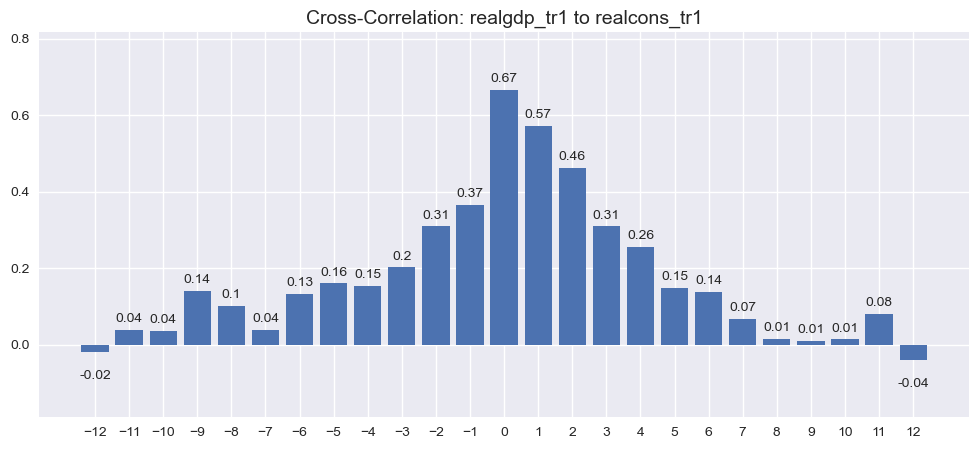

,lag,correlation
0,-12,-0.019983
1,-11,0.039299
2,-10,0.035741
3,-9,0.139894
4,-8,0.100871
5,-7,0.037944
6,-6,0.132894
7,-5,0.160392
8,-4,0.152983
9,-3,0.202026


In [101]:
macro_data['realgdp_tr1'] = macro_data['realgdp'].diff(1)
macro_data['realcons_tr1'] = macro_data['realcons'].diff(1)
macro_data['realdpi_tr1'] = macro_data['realdpi'].diff(1)
tt.cross_corr(macro_data[1:], 'realgdp_tr1', 'realcons_tr1', lags=12)

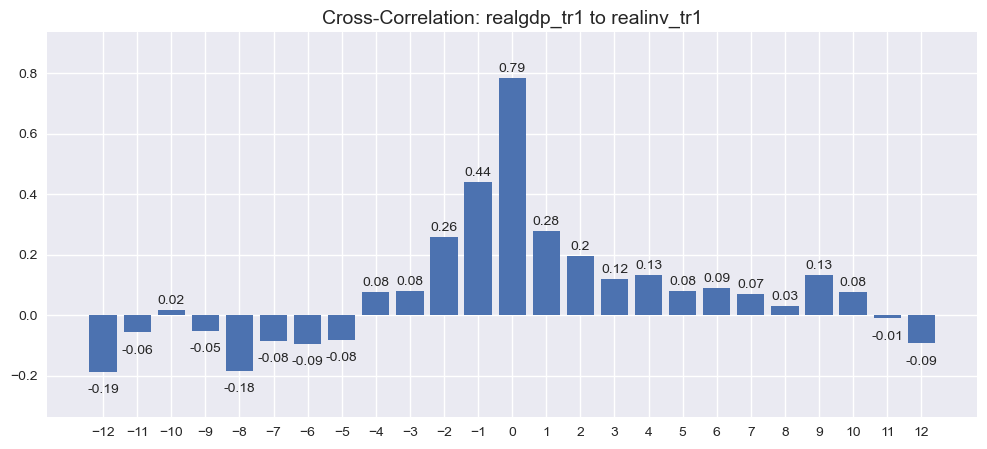

,lag,correlation
0,-12,-0.187342
1,-11,-0.056742
2,-10,0.018848
3,-9,-0.051568
4,-8,-0.184815
5,-7,-0.083920
6,-6,-0.094028
7,-5,-0.081992
8,-4,0.077134
9,-3,0.081550


In [86]:
macro_data['realinv_tr1'] = macro_data['realinv'].diff(1)
tt.cross_corr(macro_data[1:], 'realgdp_tr1', 'realinv_tr1', lags=12)

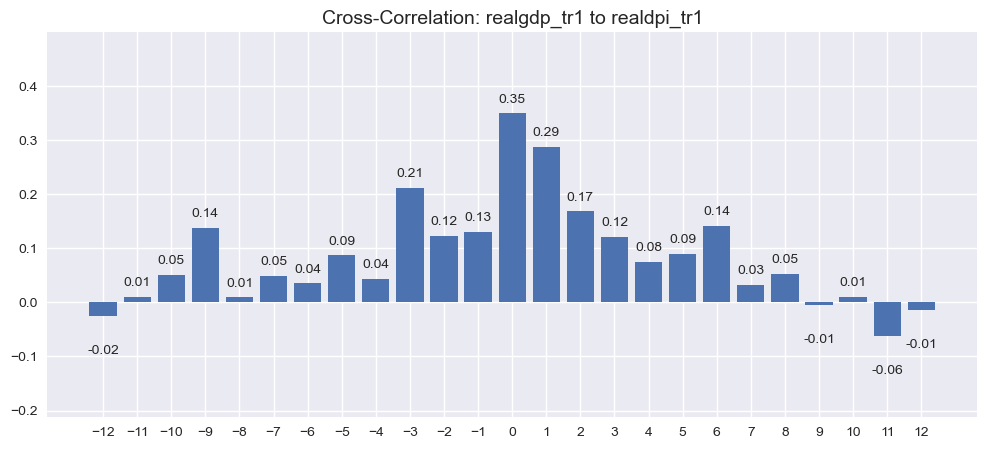

,lag,correlation
0,-12,-0.024621
1,-11,0.010677
2,-10,0.051101
3,-9,0.137948
4,-8,0.009501
5,-7,0.049538
6,-6,0.035052
7,-5,0.087033
8,-4,0.044055
9,-3,0.212500


In [87]:
tt.cross_corr(macro_data[1:], 'realgdp_tr1', 'realdpi_tr1', lags=12)

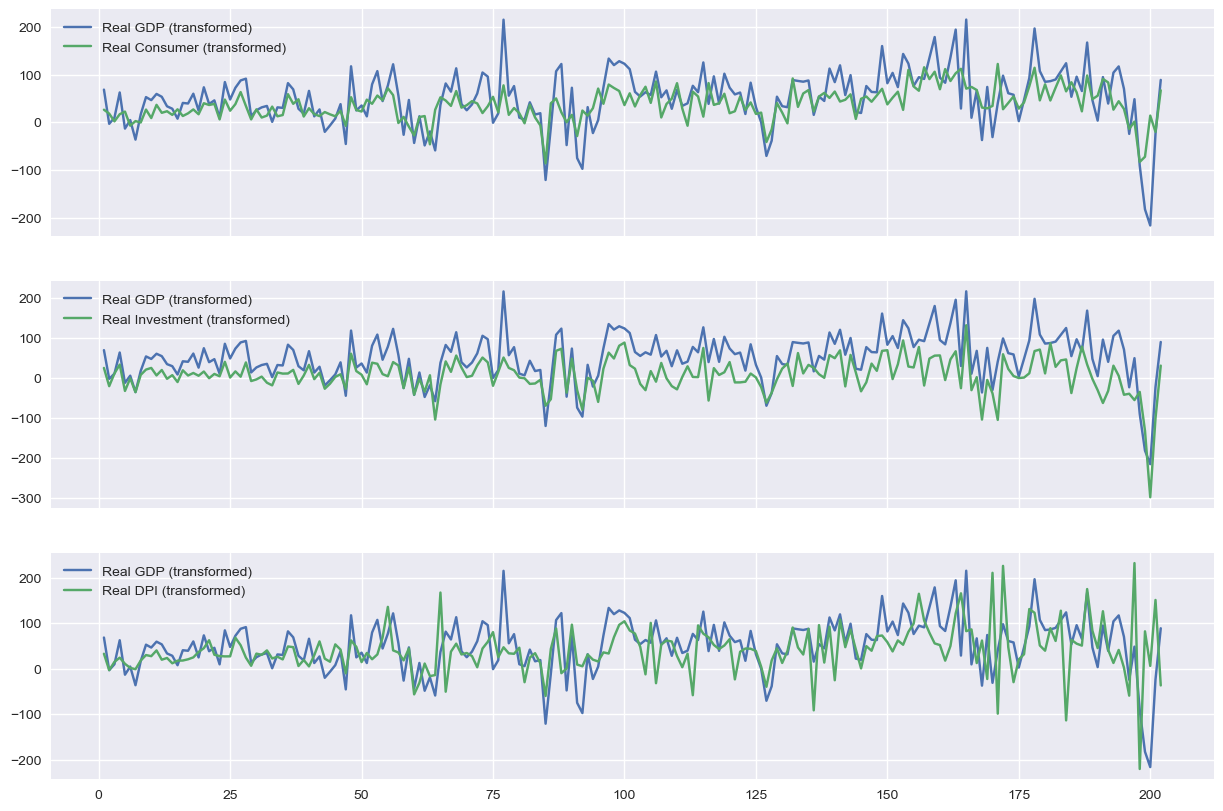

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10), sharex=True)
ax1.plot(macro_data['realgdp_tr1'], label='Real GDP (transformed)')
ax1.plot(macro_data['realcons_tr1'], label='Real Consumer (transformed)')
ax1.legend()
ax2.plot(macro_data['realgdp_tr1'], label='Real GDP (transformed)')
ax2.plot(macro_data['realinv_tr1'], label='Real Investment (transformed)')
ax2.legend()
ax3.plot(macro_data['realgdp_tr1'], label='Real GDP (transformed)')
ax3.plot(macro_data['realdpi_tr1'], label='Real DPI (transformed)')
ax3.legend()
plt.show;

In [89]:
macro_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,realgdp_tr1,realcons_tr1,realdpi_tr1,realinv_tr1
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00,NaN,NaN,NaN,NaN
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74,68.452,26.3,32.8,23.961
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09,-3.313,18.1,-3.3,-21.633
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06,9.716,1.9,14.9,10.130
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19,62.495,16.8,24.2,32.366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,-90.666,-83.3,-220.7,-35.825
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,-182.680,-72.4,82.1,-133.032
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,-216.510,13.9,6.0,-299.167
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19,-23.906,-20.2,151.1,-101.816


## Find best fit

In [90]:
ps = range(0, 5, 1) 
qs = range(0, 5, 1)
d = 1

ARIMAX_order_list = list(product(ps, qs)) 
endog_train = macro_data['realgdp'][1:-4]
endog_test = macro_data['realgdp'][-4:]
exog_train = macro_data['realinv_tr1'][1:-4]
exog_test = macro_data['realinv_tr1'][-4:]

ARIMAX_result_df = tt.optimize_ARIMAX(endog_train, exog_train, ARIMAX_order_list, d) 
ARIMAX_result_df.head(5)

  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1)",2057.442110
1,"(4, 4)",2058.233082
2,"(2, 3)",2059.413166
3,"(3, 2)",2059.426543
4,"(4, 1)",2059.460647


## ARIMAX model

In [91]:
ARIMAX_model = SARIMAX(endog_train, exog_train, (3,d,1))
ARIMAX_model_fit = ARIMAX_model.fit(disp=False)

print(ARIMAX_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  198
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -1022.721
Date:                Mon, 16 Jan 2023   AIC                           2057.442
Time:                        17:48:07   BIC                           2077.141
Sample:                             0   HQIC                          2065.417
                                - 198                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
realinv_tr1     0.4570      0.056      8.230      0.000       0.348       0.566
ar.L1           1.3270      0.087     15.217      0.000       1.156       1.498
ar.L2          -0.1097      0.131     -0.840    

## White Noise test

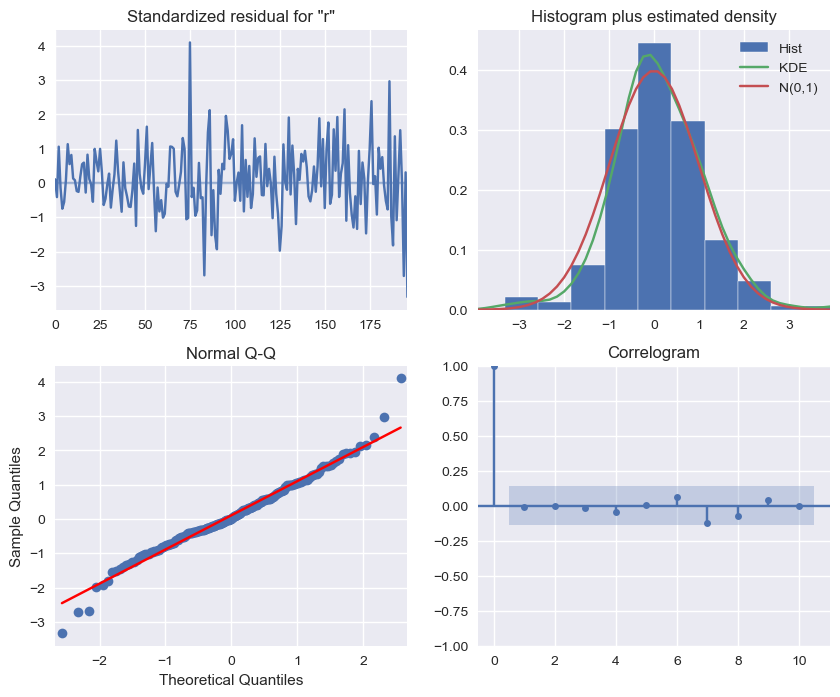

In [98]:
ARIMAX_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.99 > 0.05
The residuals are independent and not correlated.  Like white noise!


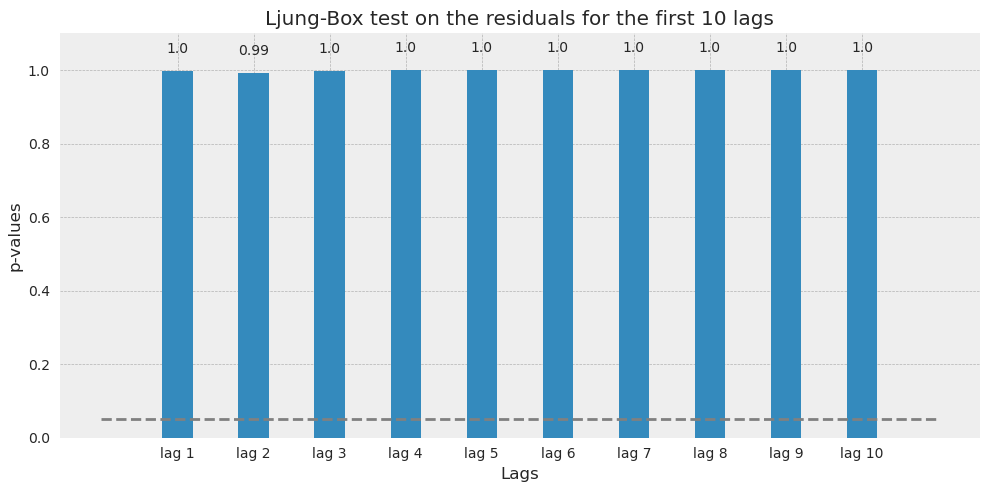

In [99]:
tt.ljungbox(ARIMAX_model_fit.resid)

## Forecast

In [92]:
pred = ARIMAX_model_fit.forecast(4, exog=exog_test) 
df_test = pd.concat([endog_test, pred], axis=1)
df_test.columns = ['realgdp_actual', 'realgdp_predicted']
df_test

,realgdp_actual,realgdp_predicted
199,13141.920,13286.969632
200,12925.410,13218.922060
201,12901.504,13340.598532
202,12990.341,13440.156384


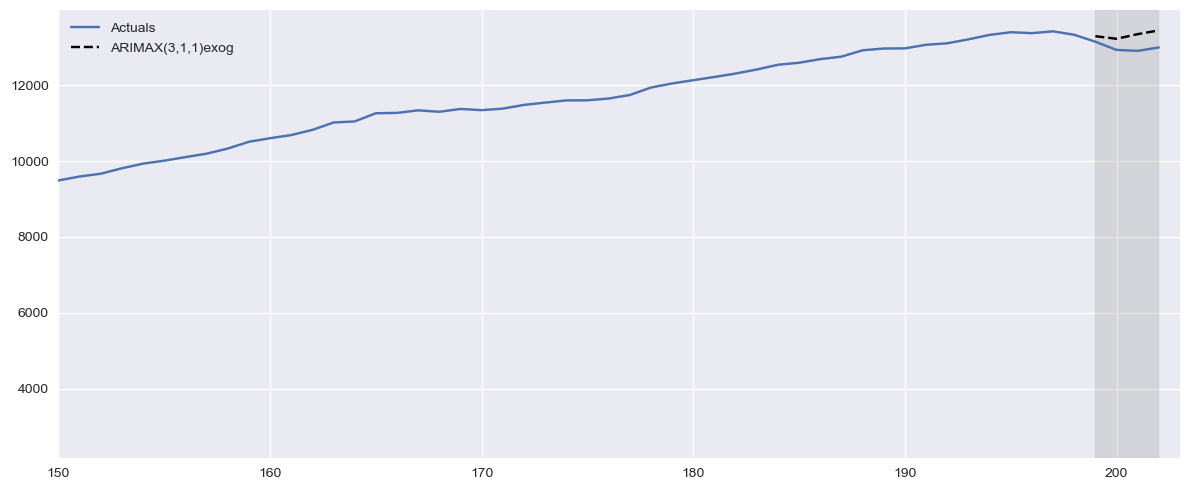

In [97]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(macro_data['realgdp'], label='Actuals')
ax.plot(df_test['realgdp_predicted'], label='ARIMAX(3,1,1)exog', color='black', ls='--')
ax.axvspan(199, 202, color='#808080', alpha=0.2)
ax.set_xlim(150, 203)
ax.legend()
plt.tight_layout();

## Granger Causality Test  
https://www.statology.org/granger-causality-test-in-python/  
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html  
https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/ 

In [104]:
from statsmodels.tsa.stattools import grangercausalitytests as gct

In [107]:
gct(macro_data[['realgdp_tr1', 'realcons_tr1']][1:], maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=47.7717 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=48.4955 , p=0.0000  , df=1
likelihood ratio test: chi2=43.4434 , p=0.0000  , df=1
parameter F test:         F=47.7717 , p=0.0000  , df_denom=198, df_num=1


{1: ({'ssr_ftest': (47.77171965256653, 6.417334980541284e-11, 198.0, 1),
   'ssr_chi2test': (48.495533586696325, 3.310419787134321e-12, 1),
   'lrtest': (43.44335720874369, 4.364106058674884e-11, 1),
   'params_ftest': (47.77171965256654, 6.417334980541284e-11, 198.0, 1.0)},
   array([[0., 1., 0.]])])}

In [105]:
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,realgdp_tr1,realcons_tr1,realdpi_tr1,realinv_tr1
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,NaN,NaN,NaN,NaN
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,68.452,26.3,32.8,23.961
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,-3.313,18.1,-3.3,-21.633
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,9.716,1.9,14.9,10.130
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,62.495,16.8,24.2,32.366


In [ ]:
plt.plot(macro_data['realgdp_tr1'])
plt.title('Transformed RealGDP')
plt.show()

In [ ]:
ad_fuller_result = adfuller(macro_data['realgdp_tr1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
plot_acf(macro_data['realgdp_tr1'][1:]);
plot_pacf(macro_data['realgdp_tr1'][1:]);

In [ ]:
def optimize_SARIMAX(endog, exog, parameters_list, d, D, s):
    """
        Returns dataframe with parameters, corresponding AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list with (p, d, P, Q)tuples
        d - integration order
        D - seasonal integration order
        s - length of the season
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog,
                           exog,
                           order=(param[0], d, param[1]),
                           seasonal_order=(param[2], D, param[3], s),
                           simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
endog = macro_data['realgdp'][:200]
exog = macro_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']][:200]

result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 0, 4)
result_df

In [ ]:
best_model = SARIMAX(endog, 
                     exog, 
                     order=(2,1,2), 
                     seasonal_order=(1,0,0,4),
                    simple_differencing=False)
res = best_model.fit(dis=False)

print(res.summary())

In [ ]:
res.plot_diagnostics();

In [ ]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast,
                            exog = exog.iloc[-4:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots()
ax.plot(macro_data['realgdp'][:199], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)

ax.set_title('Forecast of US Real GDP')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(macro_data['realgdp'], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.plot(predict.predicted_mean, 'ro')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)
ax.set_xlim(190,199)
ax.set_ylim(13000, 14100)

ax.set_title('Forcaset of RealGDP')
plt.show()

In [ ]:
mse = mean_squared_error(macro_data['realgdp'], predict.predicted_mean[:203])

print(f'MSE: {mse}')

In [ ]:
mape = np.mean(np.abs(macro_data['realgdp'] - predict.predicted_mean[:203]) / np.abs(macro_data['realgdp']))

print(f'MAPE: {round(mape * 100, 2)}%')